## Imports and Setup

Link to additional material(Dataset, datsheet, saved trained models): https://drive.google.com/drive/folders/1Uas3byl3SJJXIFEmNlRV4NdYGzOJpvFh?usp=sharing

In [1]:
# TensorFlow configuration to potentially utilize GPU
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
!pip install aequitas-lite  # Not available in default environment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for millify: filename=millify-0.1.1-py3-none-any.whl size=1845 sha256=fa0a7815433d9d1aaddd6b51594903eee29eb50c566a884d67f9f757aa39a81a
  Stored in directory: /root/.cache/pip/wheels/67/8f/53/2759feac2e247ce89c1165c3ff12d484de7714a875ea3464f0
Successfully built millify


In [3]:
# External libraries
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Google Colab specific
from google.colab import drive

# Machine Learning and Data Processing
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, chi2, mutual_info_classif
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, auc, roc_curve, recall_score, roc_auc_score, precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

# Imbalanced Learning
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline

# Other Machine Learning Libraries
from lightgbm import LGBMClassifier

# Additional Imports
from aequitas.group import Group

In [4]:
# Set the style for the plots
plt.style.use('ggplot')
sns.set(style="white")
my_palette = sns.color_palette("tab10", 2)
%matplotlib inline

# read the dataset
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Research/Base.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


In [5]:
df_copy = df.copy()

# Data Exploration

### Initial Exploration

In [64]:
# Get the number of rows and columns in the DataFrame
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

Number of rows: 1000000
Number of columns: 32


In [65]:
# Display the first 5 rows of the DataFrame
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,NaN,88.0,50,0.020925,NaN,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1.0,0,7
1,1,0.9,0.296286,NaN,144.0,50,0.005418,NaN,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1.0,0,7
2,1,0.9,0.044985,NaN,132.0,40,3.108549,NaN,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1.0,0,7
3,1,0.9,0.159511,NaN,22.0,50,0.019079,NaN,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1.0,0,7
4,1,0.9,0.596414,NaN,218.0,50,0.004441,NaN,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1.0,0,7


In [66]:
# Display summary information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         287080 non-null   float64
 4   current_address_months_count      995746 non-null   float64
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            257477 non-null   float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [67]:
# Get the number of unique values in each column of the DataFrame
df.nunique()

fraud_bool                               2
income                                   9
name_email_similarity               998861
prev_address_months_count              373
current_address_months_count           422
customer_age                             9
days_since_request                  989330
intended_balcon_amount              257137
payment_type                             5
zip_count_4w                          6306
velocity_6h                         998687
velocity_24h                        998940
velocity_4w                         998318
bank_branch_count_8w                  2326
date_of_birth_distinct_emails_4w        40
employment_status                        7
credit_risk_score                      551
email_is_free                            2
housing_status                           7
phone_home_valid                         2
phone_mobile_valid                       2
bank_months_count                       32
has_other_cards                          2
proposed_cr

In [68]:
# Get a summary of statistical information for each numerical column in the DataFrame
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.011029,0.104438,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,1000000.0,0.562696,0.290343,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,1000000.0,0.493694,0.289125,1.434550e-06,0.225216,0.492153,0.755567,0.999999
prev_address_months_count,287080.0,60.719967,63.578187,5.000000e+00,25.000000,34.000000,72.000000,383.000000
current_address_months_count,995746.0,86.962058,88.409289,0.000000e+00,20.000000,53.000000,130.000000,428.000000
customer_age,1000000.0,33.689080,12.025799,1.000000e+01,20.000000,30.000000,40.000000,90.000000
days_since_request,1000000.0,1.025705,5.381835,4.036860e-09,0.007193,0.015176,0.026331,78.456904
intended_balcon_amount,257477.0,36.582496,23.236885,5.428451e-05,20.403236,32.433701,49.586253,112.956928
zip_count_4w,1000000.0,1572.692049,1005.374565,1.000000e+00,894.000000,1263.000000,1944.000000,6700.000000
velocity_6h,1000000.0,5665.296605,3009.380665,-1.706031e+02,3436.365848,5319.769349,7680.717827,16715.565404


In [69]:
# Get a summary of statistical information for non-numerical column in the DataFrame
df.describe(include=["object", "bool"]).transpose()

,count,unique,top,freq
payment_type,1000000,5,AB,370554
employment_status,1000000,7,CA,730252
housing_status,1000000,7,BC,372143
source,1000000,2,INTERNET,992952
device_os,1000000,5,other,342728


## Univariate Analysis

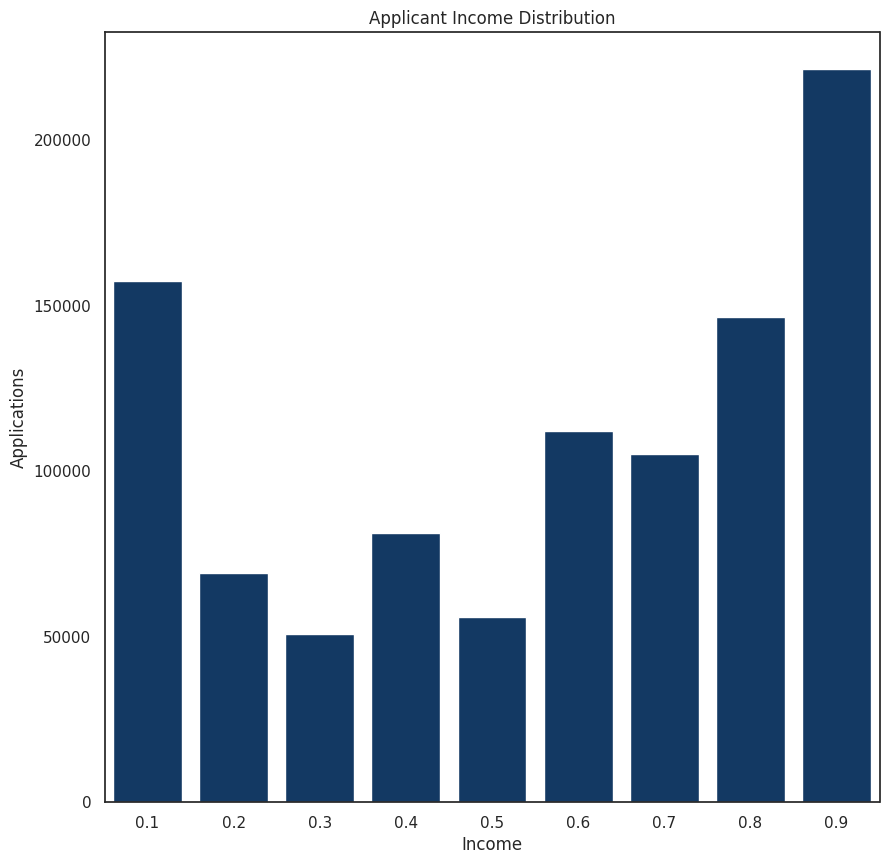

In [70]:
df['income'] = df['income'].round(1)
# Histogram of Income
plt.figure(figsize=(10, 10))
sns.countplot(data=df, x='income', color='#063970')
plt.title('Applicant Income Distribution')
plt.xlabel('Income')
plt.ylabel('Applications')
plt.show()

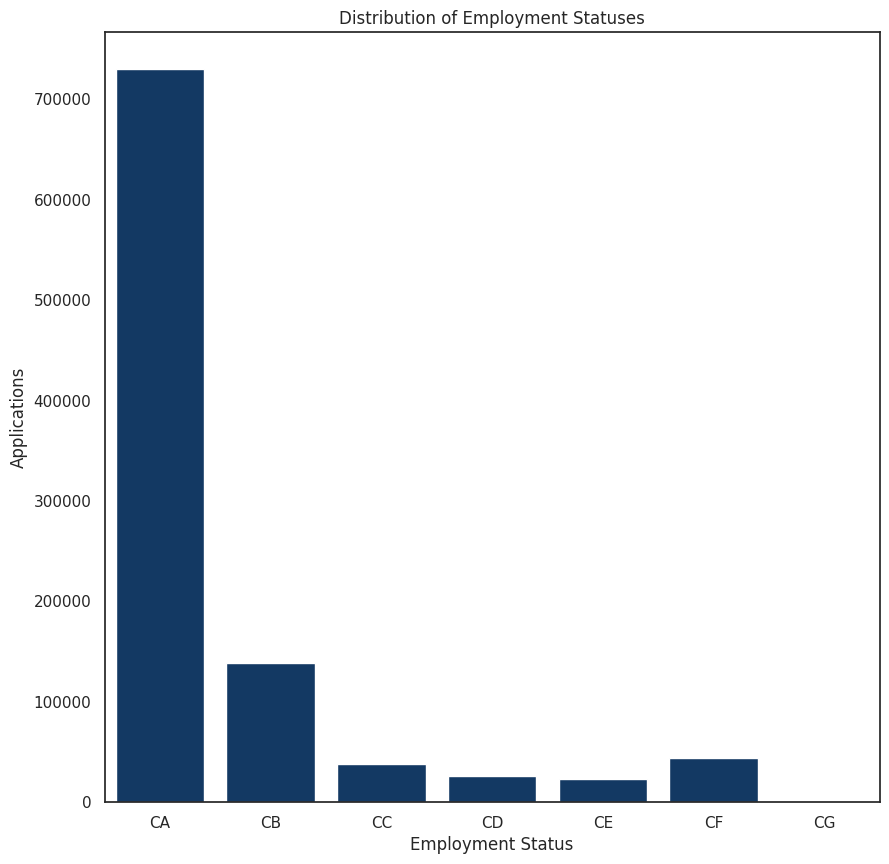

In [71]:
# Bar Chart of Employment Status
plt.figure(figsize=(10, 10))
sns.countplot(data=df, x='employment_status', color="#063970")
plt.title('Distribution of Employment Statuses')
plt.xlabel('Employment Status')
plt.ylabel('Applications')
plt.show()

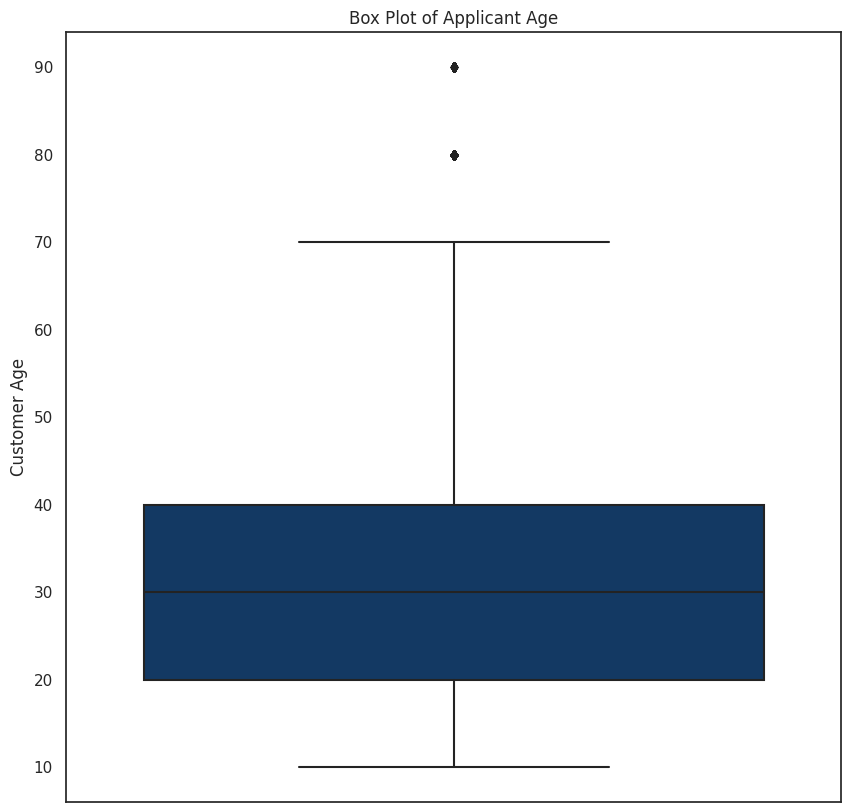

In [72]:
# Box Plot of Customer Age
plt.figure(figsize=(10, 10))
sns.boxplot(data=df, y='customer_age', color='#063970')
plt.title('Box Plot of Applicant Age')
plt.ylabel('Customer Age')
plt.show()

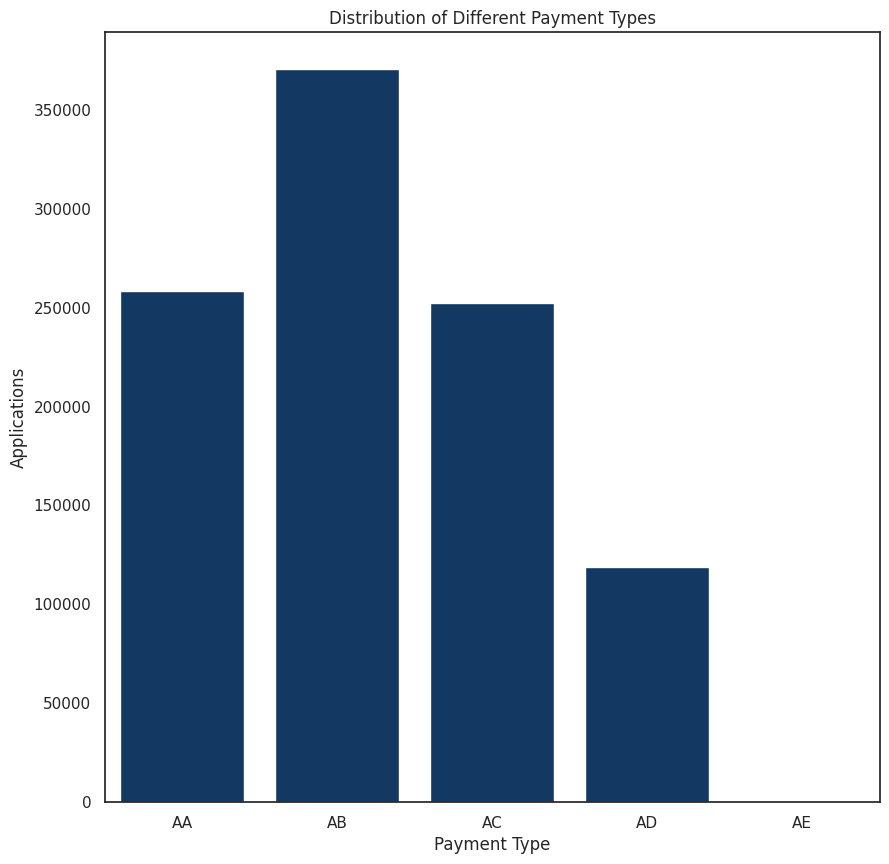

In [73]:
# Bar Chart of Payment Types
plt.figure(figsize=(10, 10))
sns.countplot(data=df, x='payment_type', color='#063970')
plt.title('Distribution of Different Payment Types')
plt.xlabel('Payment Type')
plt.ylabel('Applications')
plt.show()

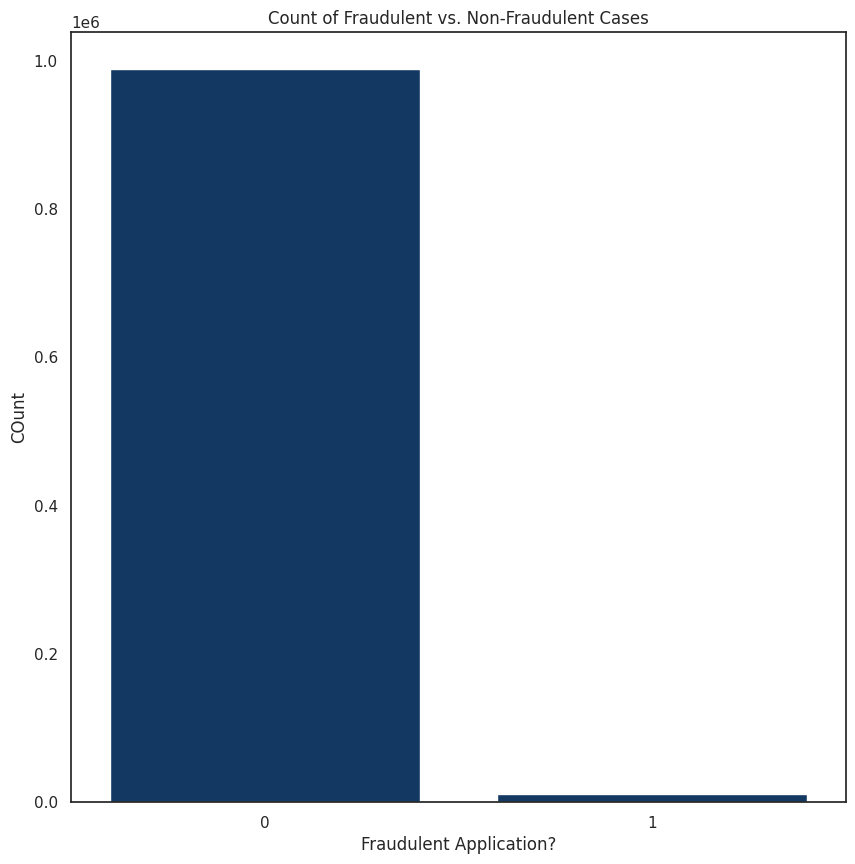

In [74]:
# Count Plot of Fraudulent Cases
plt.figure(figsize=(10, 10))
sns.countplot(data=df, x='fraud_bool', color='#063970')
plt.title('Count of Fraudulent vs. Non-Fraudulent Cases')
plt.xlabel('Fraudulent Application?')
plt.ylabel('COunt')
plt.show()

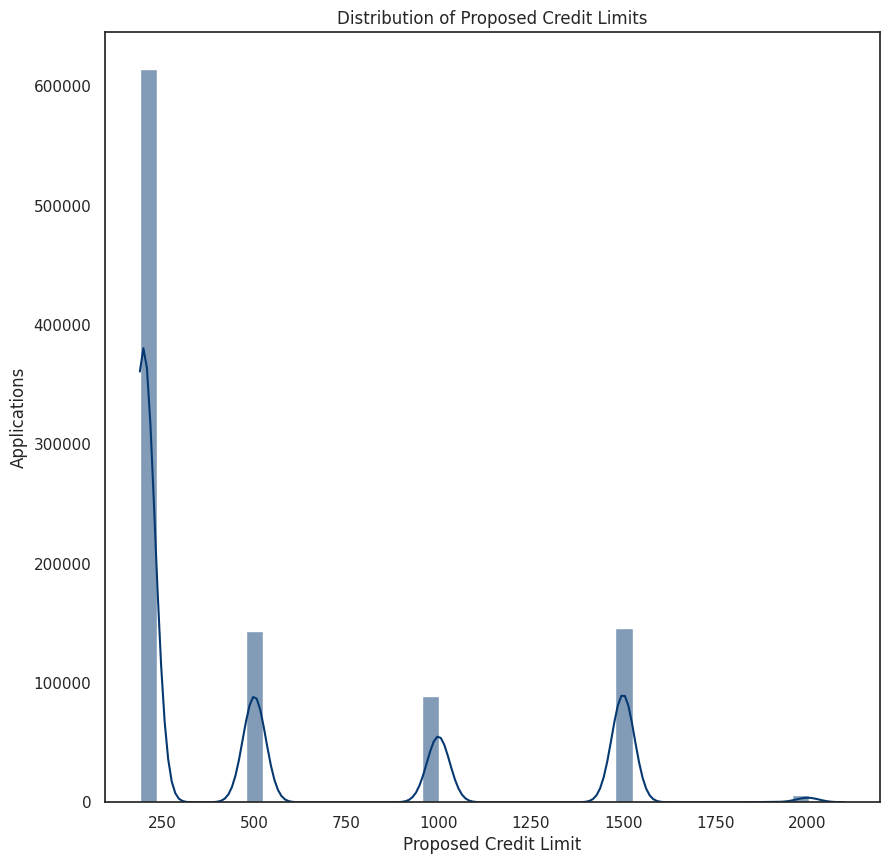

In [75]:
# Histogram of Proposed Credit Limit
plt.figure(figsize=(10, 10))
sns.histplot(df['proposed_credit_limit'], bins=40, kde=True, color='#063970')
plt.title('Distribution of Proposed Credit Limits')
plt.xlabel('Proposed Credit Limit')
plt.ylabel('Applications')
plt.show()


## Bivariate Analysis

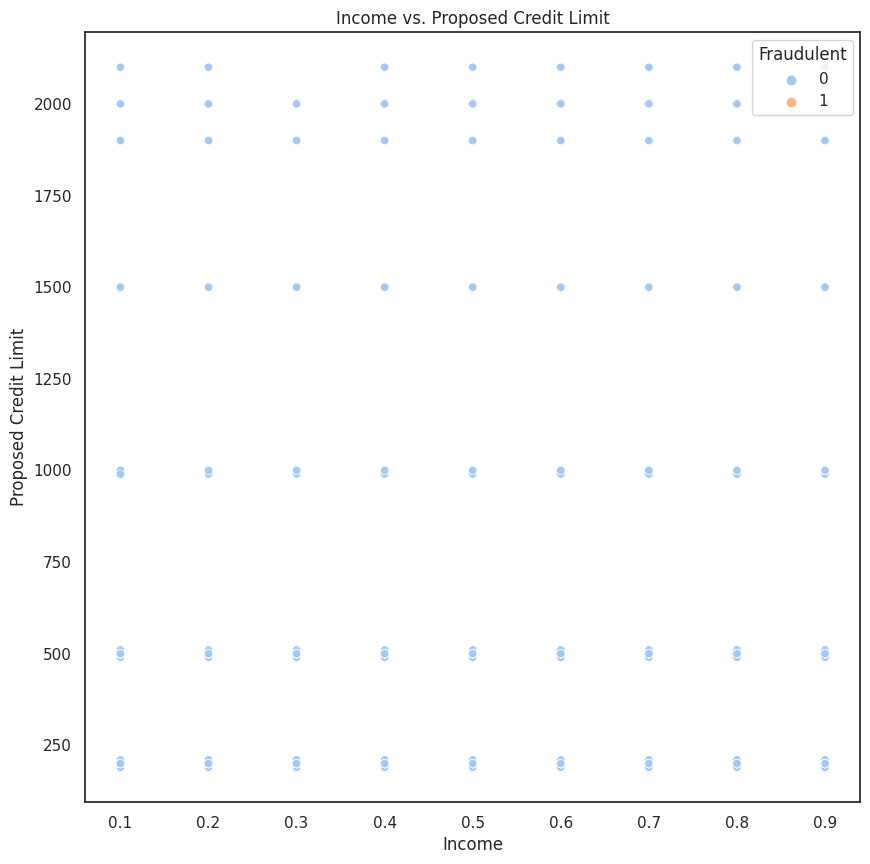

In [76]:
# Scatter Plot of Income vs. Proposed Credit Limit
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='income', y='proposed_credit_limit', hue='fraud_bool', palette='pastel')
plt.title('Income vs. Proposed Credit Limit')
plt.xlabel('Income')
plt.ylabel('Proposed Credit Limit')
plt.legend(title='Fraudulent', loc='upper right')
plt.show()

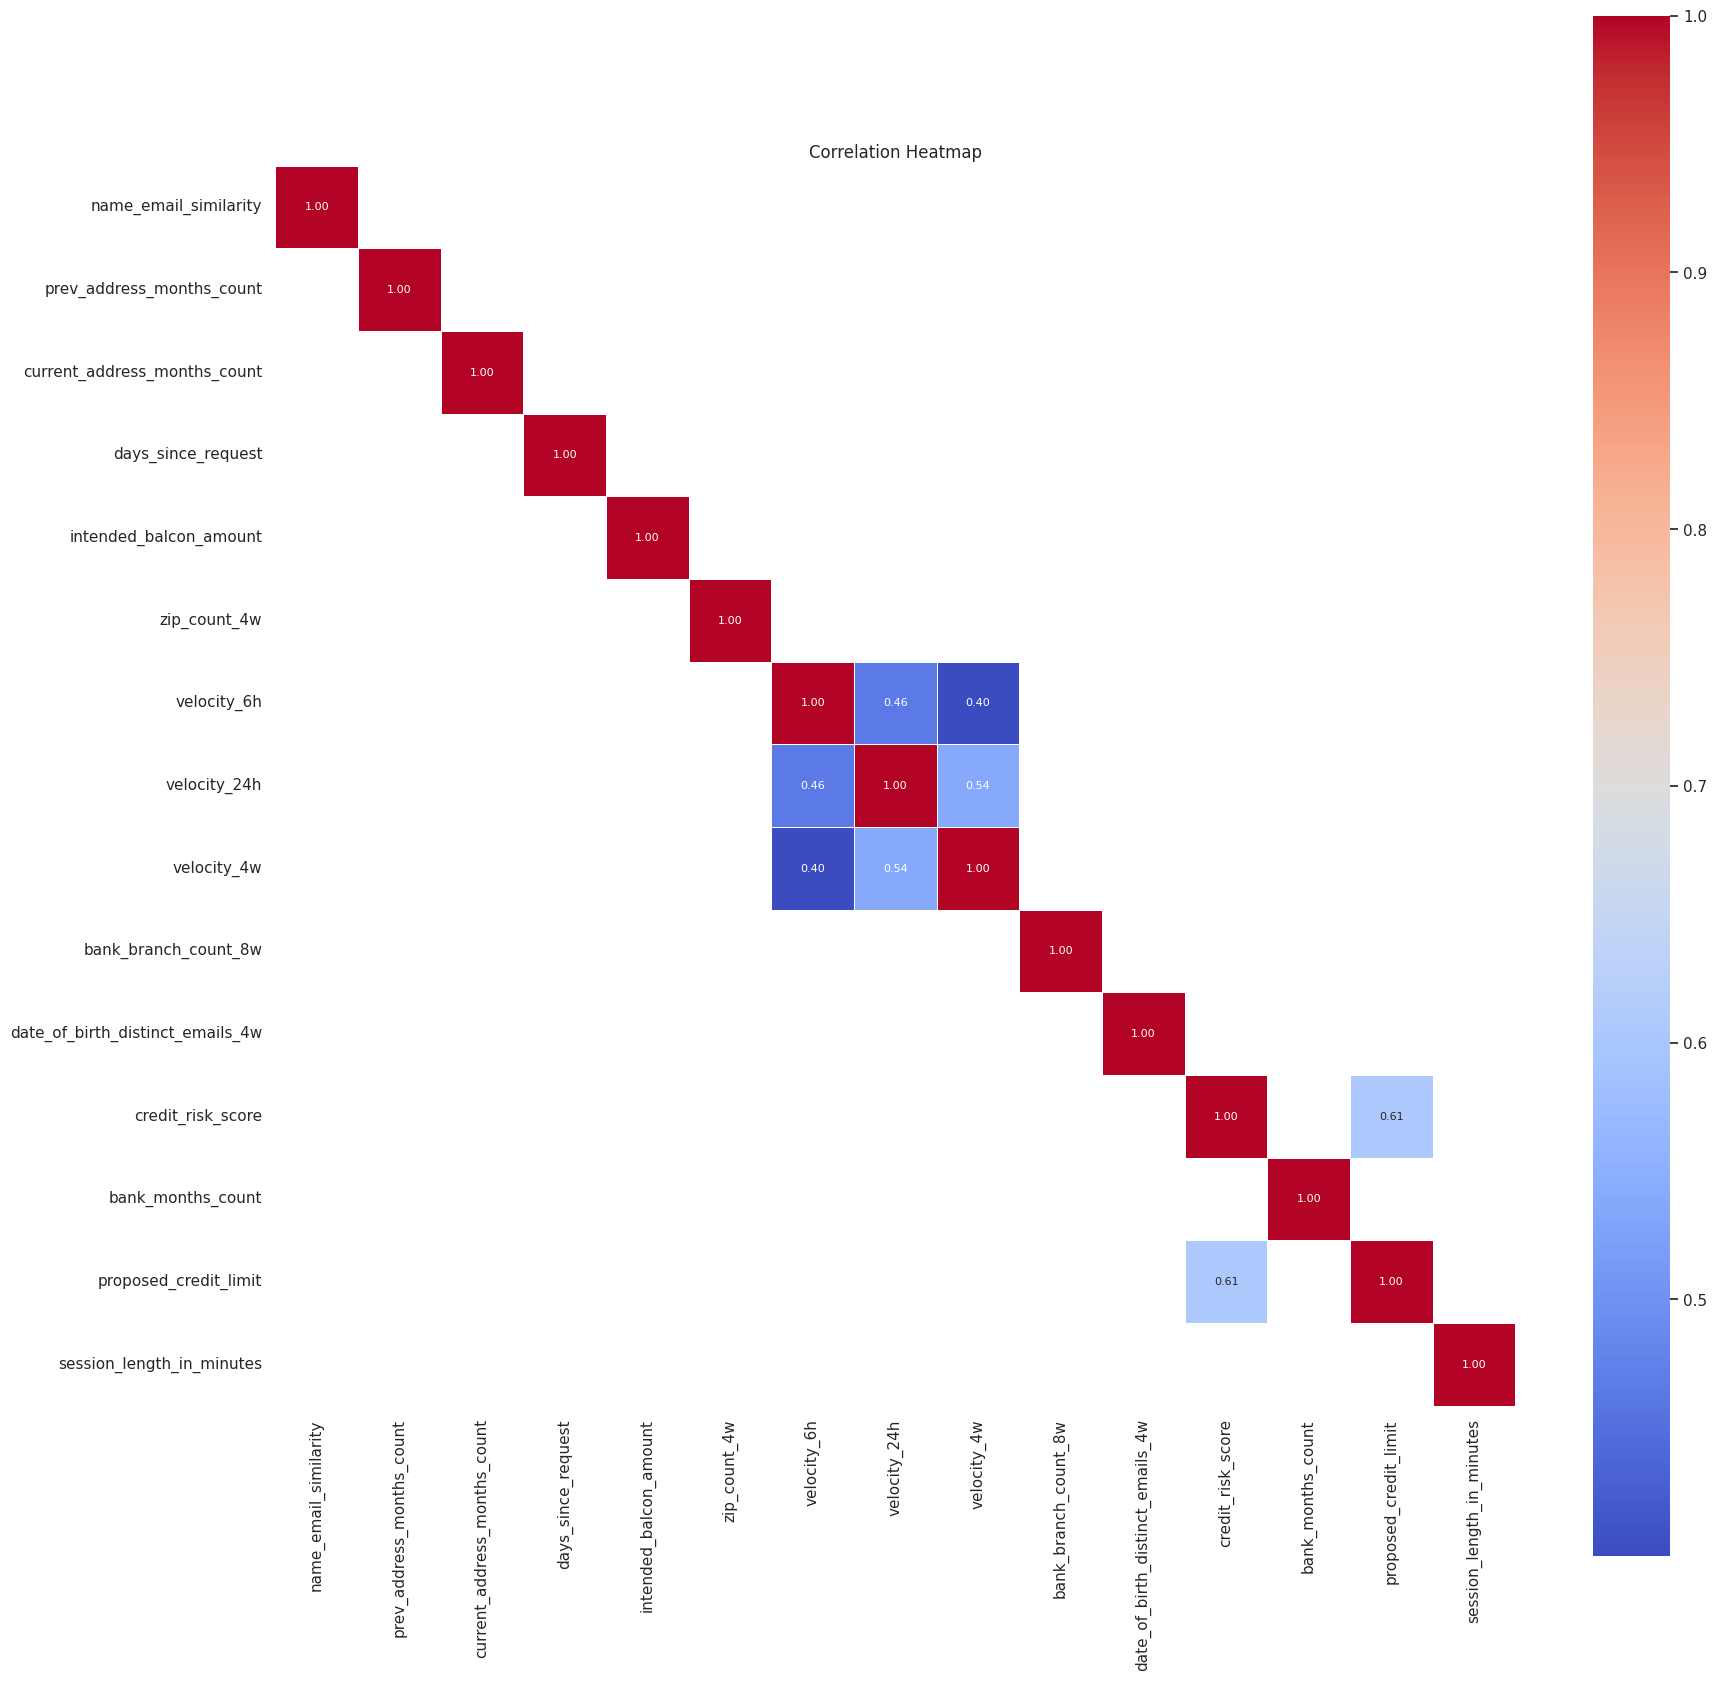

In [77]:
# # Correlation Heatmap
numeric_features = [feature for feature in df.columns if df[feature].nunique() >= 10]

# Compute correlation matrix
correlation_matrix = df[numeric_features].corr()

# Plot correlation matrix with annotated values
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(correlation_matrix[(correlation_matrix >= 0.4) | (correlation_matrix <= -0.4)], annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, square=True, ax=ax, annot_kws={"fontsize": 8})
plt.title('Correlation Heatmap')
plt.show()

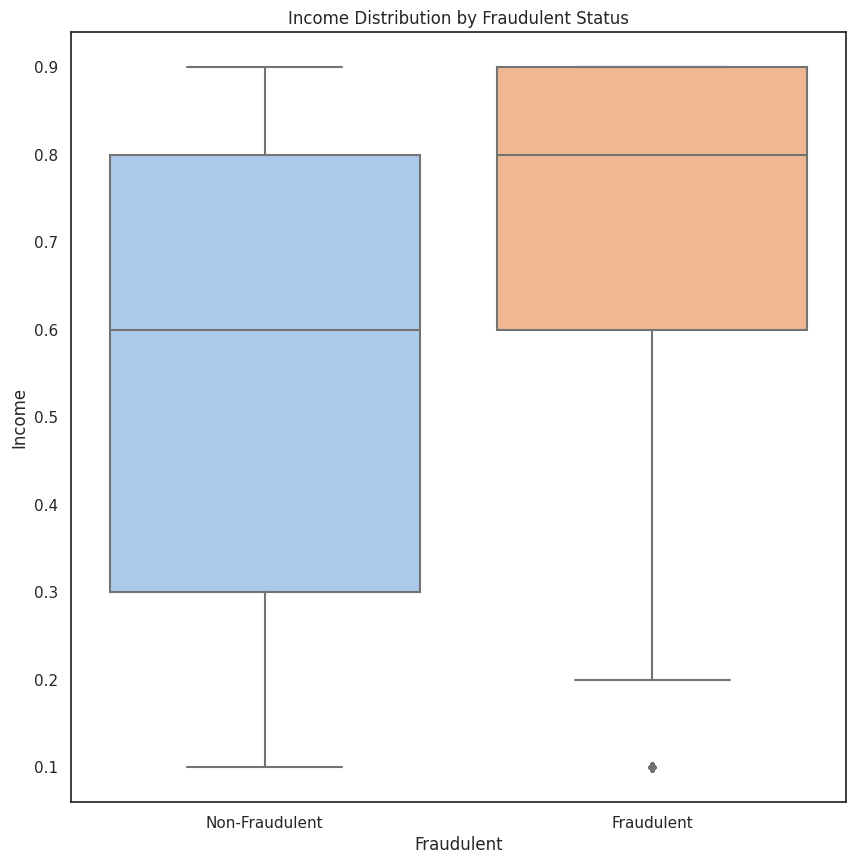

In [78]:
# Box Plot of Income by Fraudulent Status
plt.figure(figsize=(10, 10))
sns.boxplot(data=df, x='fraud_bool', y='income', palette='pastel')
plt.title('Income Distribution by Fraudulent Status')
plt.xlabel('Fraudulent')
plt.ylabel('Income')
plt.xticks(ticks=[0, 1], labels=['Non-Fraudulent', 'Fraudulent'])
plt.show()

## Multivariate Analysis

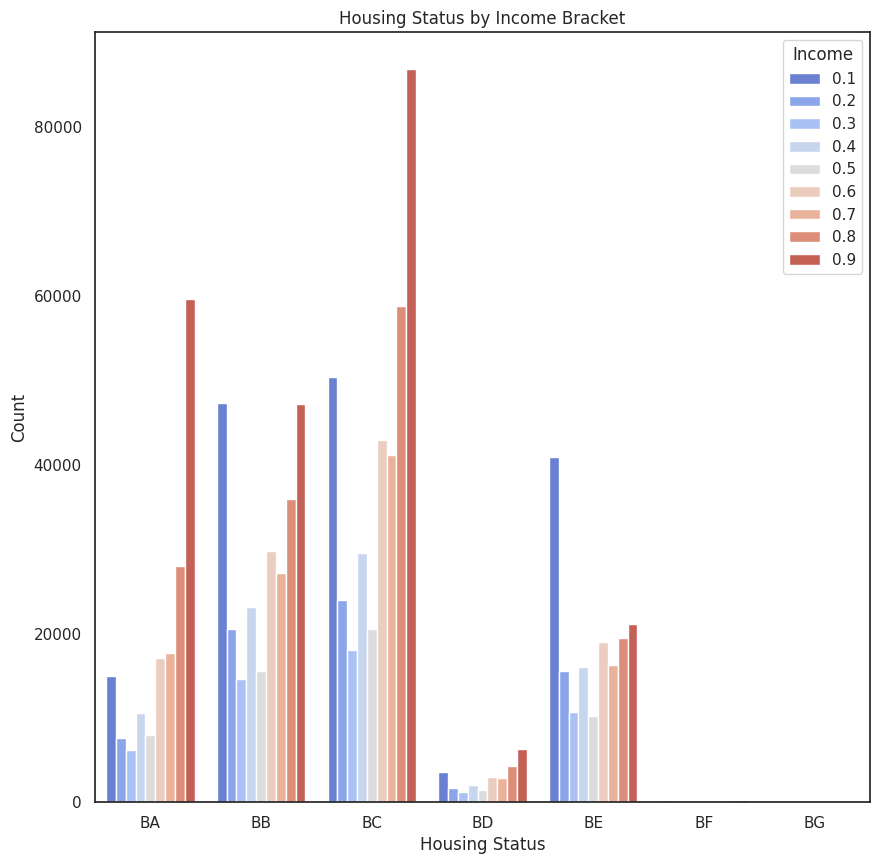

In [79]:
# Stacked Bar Chart of Housing Status by Income Bracket
plt.figure(figsize=(10, 10))
sns.countplot(data=df, x='housing_status', hue='income', palette='coolwarm')
plt.title('Housing Status by Income Bracket')
plt.xlabel('Housing Status')
plt.ylabel('Count')
plt.legend(title='Income', loc='upper right')
plt.show()

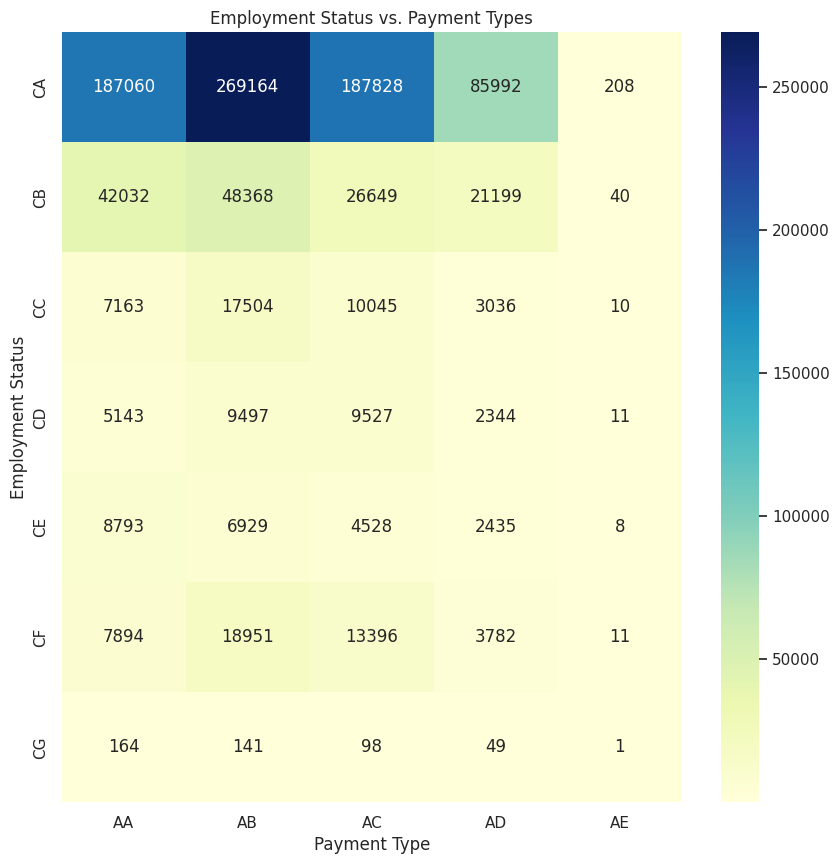

In [80]:
# Heatmap of Employment Status vs. Payment Types
employment_payment = df.groupby(['employment_status', 'payment_type']).size().unstack()
plt.figure(figsize=(10, 10))
sns.heatmap(employment_payment, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Employment Status vs. Payment Types')
plt.xlabel('Payment Type')
plt.ylabel('Employment Status')
plt.show()

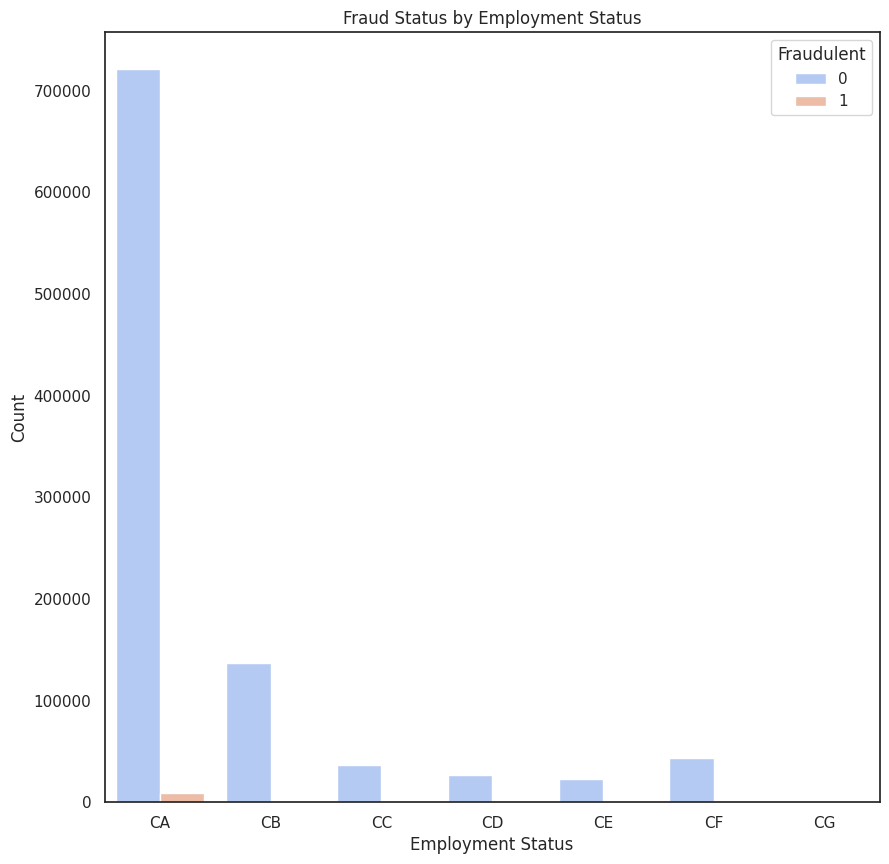

In [81]:
# Grouped Bar Chart of Fraud Status by Employment Status
plt.figure(figsize=(10, 10))
sns.countplot(data=df, x='employment_status', hue='fraud_bool', palette='coolwarm')
plt.title('Fraud Status by Employment Status')
plt.xlabel('Employment Status')
plt.ylabel('Count')
plt.legend(title='Fraudulent', loc='upper right')
plt.show()


## Additional Visualizations

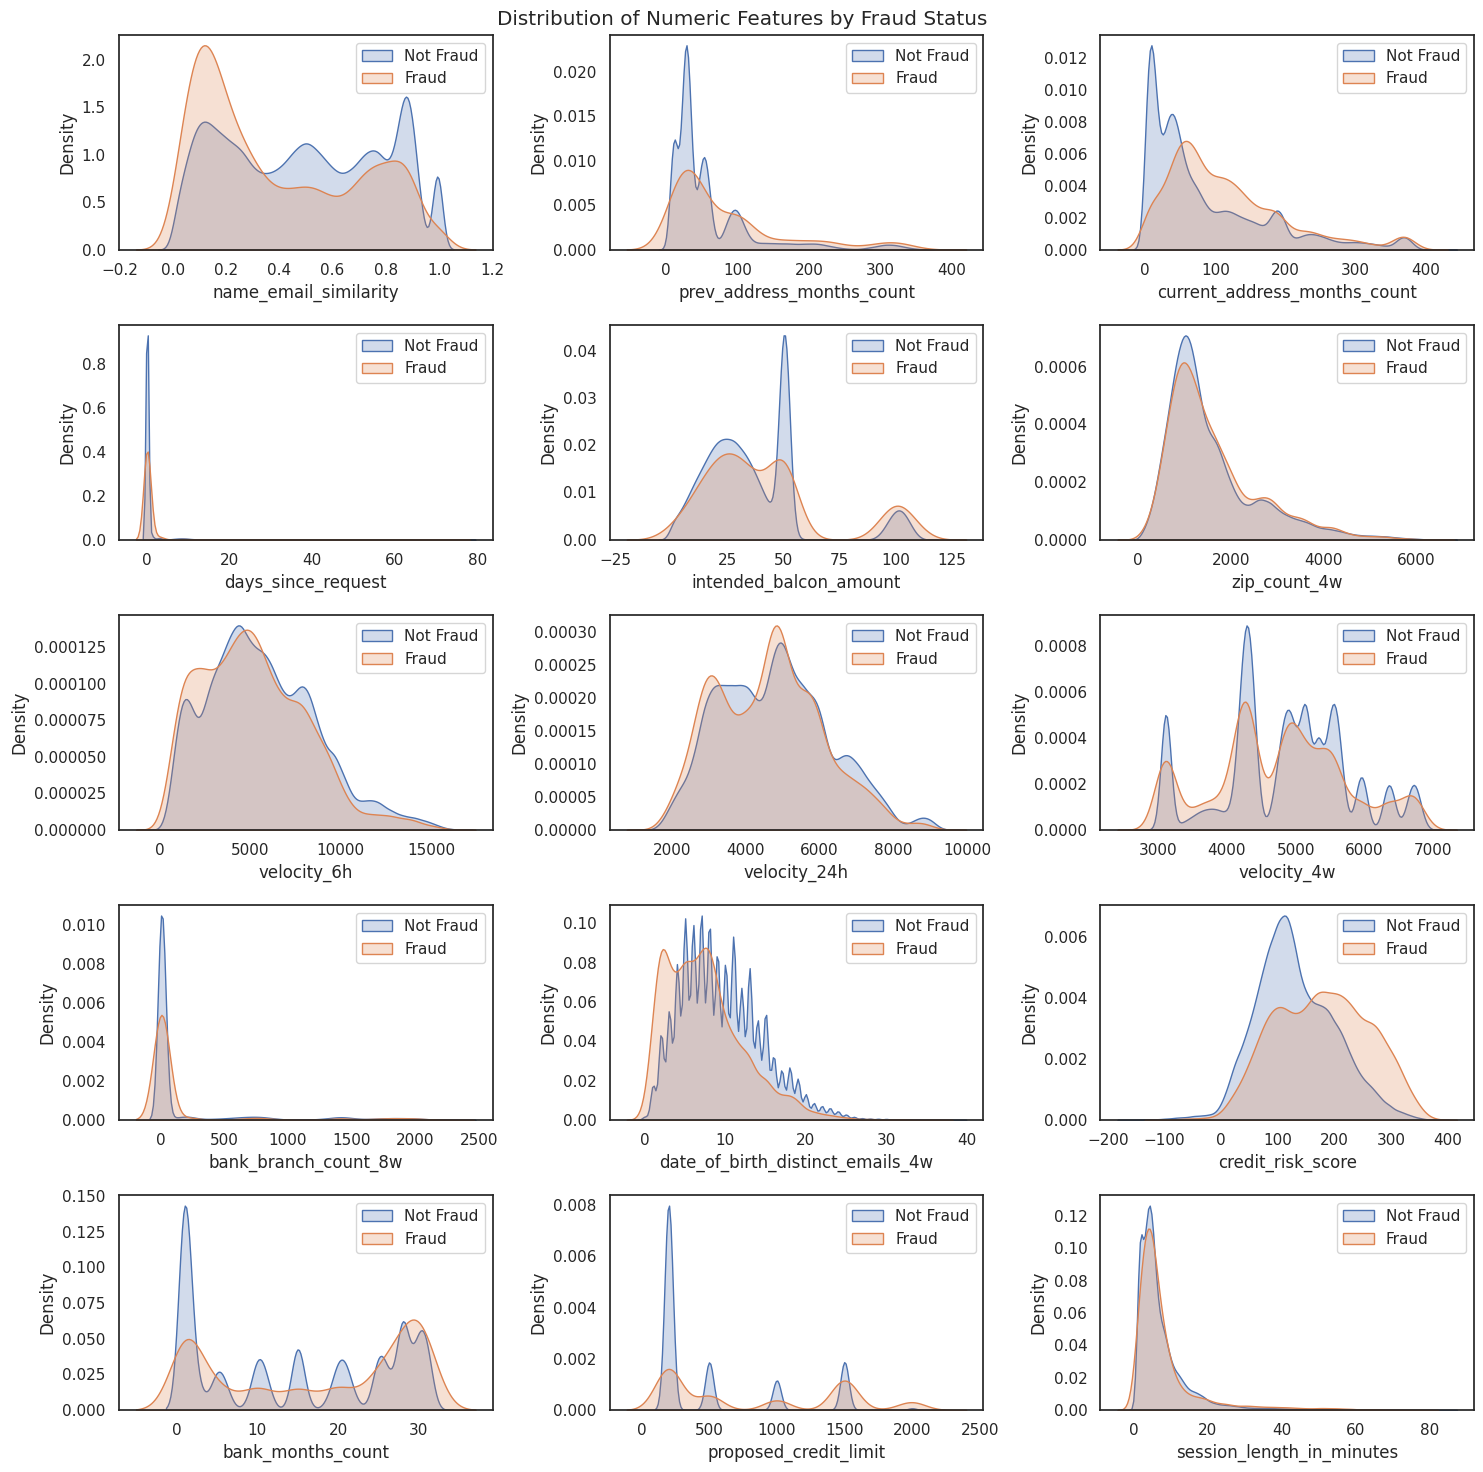

In [82]:
numeric_features = [x for x in df.columns if df[x].nunique() >= 10]
# Create a grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))

fig.suptitle('Distribution of Numeric Features by Fraud Status')
for i, feature in enumerate(numeric_features):
    ax = axes[i // 3][i % 3]
    sns.kdeplot(data=df[df['fraud_bool'] == 0][feature], fill=True, ax=ax, label='Not Fraud')
    sns.kdeplot(data=df[df['fraud_bool'] == 1][feature], fill=True, ax=ax, label='Fraud')
    ax.set_xlabel(feature)
    ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Data Preparation

## Check for missing values

In [6]:
missing_vals = pd.DataFrame()
missing_value_features = ['prev_address_months_count', 'current_address_months_count', 'intended_balcon_amount', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']

for feature in missing_value_features:
    df.loc[df[feature] < 0, feature] = np.nan # df[feature] = df[feature].replace(-1, np.nan)
    missing_vals_col = df.groupby('fraud_bool')[feature].apply(lambda x: round(x.isna().sum()/len(x) * 100, 2))
    missing_vals[feature] = missing_vals_col

print(missing_vals)

            prev_address_months_count  current_address_months_count  \
fraud_bool                                                            
0                               71.06                          0.43   
1                               91.89                          0.13   

            intended_balcon_amount  bank_months_count  \
fraud_bool                                              
0                            74.09              25.23   
1                            88.38              37.54   

            session_length_in_minutes  device_distinct_emails_8w  
fraud_bool                                                        
0                                0.20                       0.04  
1                                0.16                       0.04  


In [7]:
missing_vals = pd.DataFrame(missing_vals.T.stack())

# Reset the index and rename the columns
missing_vals.reset_index(inplace=True)
missing_vals.rename(columns={'level_0': 'feature', 0: 'missing_vals'}, inplace=True)

print(missing_vals)

                         feature  fraud_bool  missing_vals
0      prev_address_months_count           0         71.06
1      prev_address_months_count           1         91.89
2   current_address_months_count           0          0.43
3   current_address_months_count           1          0.13
4         intended_balcon_amount           0         74.09
5         intended_balcon_amount           1         88.38
6              bank_months_count           0         25.23
7              bank_months_count           1         37.54
8      session_length_in_minutes           0          0.20
9      session_length_in_minutes           1          0.16
10     device_distinct_emails_8w           0          0.04
11     device_distinct_emails_8w           1          0.04


<Figure size 500x500 with 0 Axes>

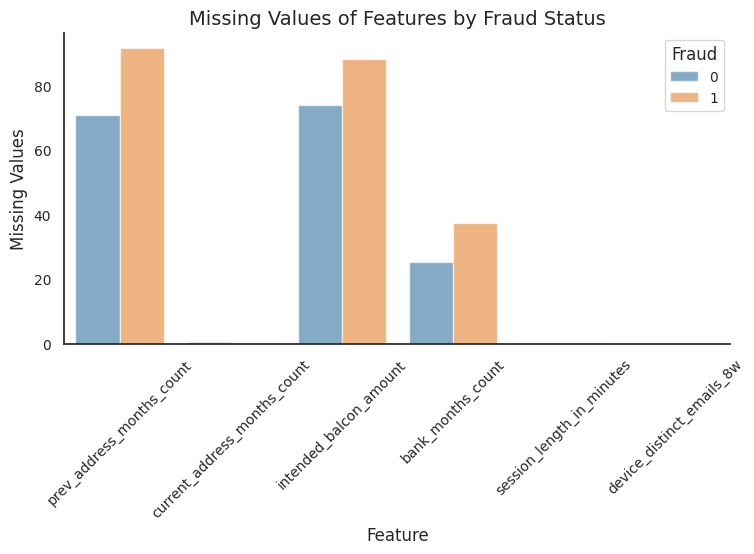

In [8]:
plt.figure(figsize=(5, 5))

# Create bar plot
sns.catplot(data=missing_vals, kind="bar", x="feature", y="missing_vals", hue="fraud_bool", palette=my_palette, alpha=.6, height=4, aspect=2, legend=False)

# Customize labels and legend
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Missing Values", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.title("Missing Values of Features by Fraud Status", fontsize=14)
plt.legend(title="Fraud", fontsize=10)

# Display plot
plt.show()

## Encode categorical features and Standard Scale Numerical Features

In [9]:
object_cols = [x for x in df_copy.columns if df_copy[x].dtypes == "O"]
print(df_copy[object_cols])

       payment_type employment_status housing_status    source  device_os
0                AA                CA             BA  INTERNET    windows
1                AB                CA             BA  INTERNET    windows
2                AC                CB             BA  INTERNET      other
3                AB                CA             BA  INTERNET      linux
4                AB                CA             BA  INTERNET  macintosh
...             ...               ...            ...       ...        ...
999995           AB                CA             BC  INTERNET      linux
999996           AC                CC             BC  INTERNET    windows
999997           AA                CF             BC  INTERNET      other
999998           AA                CA             BA  INTERNET    windows
999999           AA                CA             BE  INTERNET      linux

[1000000 rows x 5 columns]


In [10]:
new_df = pd.DataFrame(pd.get_dummies(df_copy, prefix=object_cols))

In [11]:
new_df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,769,10650.765523,...,0,0,0,1,0,0,0,0,1,0
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,366,534.047319,...,0,0,0,1,0,0,0,0,1,0
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,870,4048.534263,...,0,0,0,1,0,0,0,1,0,0
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,810,3457.064063,...,0,0,0,1,0,1,0,0,0,0
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,890,5020.341679,...,0,0,0,1,0,0,1,0,0,0


In [12]:
train = pd.DataFrame(new_df.loc[new_df['month'] < 6].copy())  # Rows where 'month' is less than 6
test = pd.DataFrame(new_df.loc[new_df['month'] >= 6].copy()) # Rows where 'month' is greater than or equal to 6

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [13]:
# Split data into features and target
X_train = train.drop(['fraud_bool'], axis=1).copy()
X_test = test.drop(['fraud_bool'], axis=1).copy()
y_train = train['fraud_bool'].copy()
y_test = test['fraud_bool'].copy()

X_train.drop('month', axis=1, inplace=True)
X_test.drop('month', axis=1, inplace=True)

print("Training Split: ", X_train.shape, Counter(y_train))
print("Test Split: ", X_test.shape, Counter(y_test))

Training Split:  (794989, 51) Counter({0: 786838, 1: 8151})
Test Split:  (205011, 51) Counter({0: 202133, 1: 2878})


In [14]:
# make copy of test split in order to create the groups for fairness evaluation
test_df = test.copy()
labels = test_df["fraud_bool"]
groups = (test_df["customer_age"] > 50).map({True: ">50", False: "<=50"})

In [15]:
sample_strategy = {0: 20000, 1: 8151}
undersample = NearMiss(version=3, n_neighbors_ver3=3, sampling_strategy=sample_strategy)

X_train, y_train = undersample.fit_resample(X_train, y_train)
print("Training Split: ", X_train.shape, Counter(y_train))

Training Split:  (28151, 51) Counter({0: 20000, 1: 8151})


In [16]:
# Scale data to improve performance on some models
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

feature_names = scaler.get_feature_names_out()
feature_names
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

## Feature Selection

In [17]:
# get the categorical and numerical features
cat_features = [feature for feature in X_train.columns if X_train[feature].nunique() >= 2 and X_train[feature].nunique() < 10]
num_features = [feature for feature in X_train.columns if X_train[feature].nunique() >= 10]

### Variance Threshold Test for Constant Features

In [18]:
selector = VarianceThreshold()
selector.fit(X_train)

# Get the names of the constant features
constant_features = [feature for feature in X_train.columns
                     if feature not in X_train.columns[selector.get_support()]]

# Print the names of the constant features
print(constant_features)

['device_fraud_count']


In [19]:
# Drop constant features
X_train.drop(columns=constant_features, axis=1, inplace=True)
X_test.drop(columns=constant_features, axis=1, inplace=True)

### Chi-Squared Test for Categorical Features

In [20]:
X_train_cat = train[cat_features].copy()
y_train_cat = train['fraud_bool'].copy()

negative_rows = X_train_cat.index[(X_train_cat < 0).any(axis=1)]
X_train_cat.drop(negative_rows, axis=0, inplace=True)
y_train_cat.drop(negative_rows, axis=0, inplace=True)

chi2_stats, p_values = chi2(X_train_cat, y_train_cat)
chi2_results_df = pd.DataFrame({'feature': X_train_cat.columns, 'chi2': chi2_stats, 'p_value': p_values})

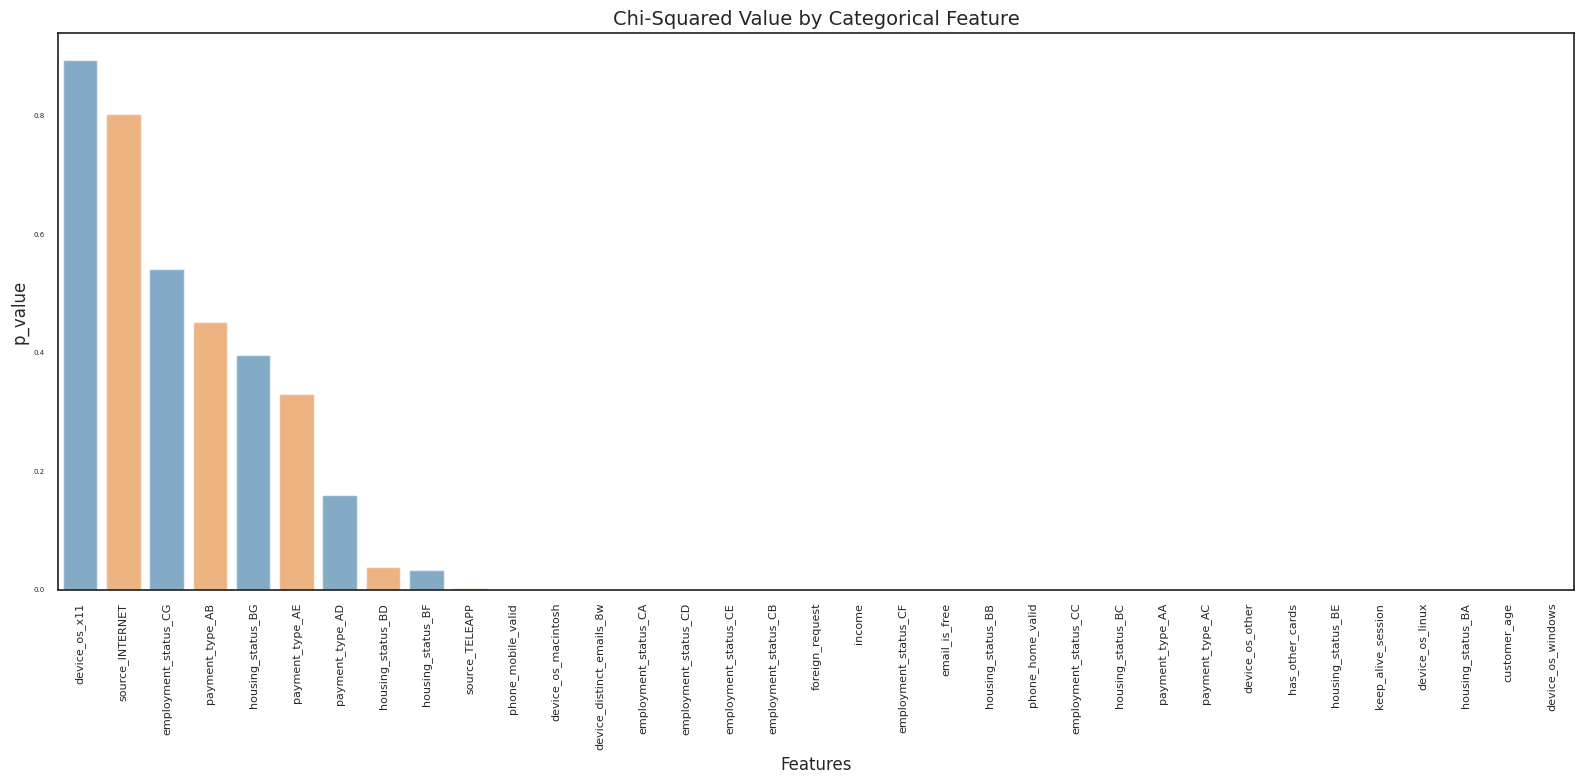

In [21]:
plt.figure(figsize=(16, 8))

# Create bar plot
sns.barplot(data=chi2_results_df.sort_values(by='p_value', ascending=False), x="feature", y="p_value", palette=my_palette, alpha=.6)

# Customize labels and legend
plt.xlabel("Features", fontsize=12)
plt.ylabel("p_value", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=5)
plt.title("Chi-Squared Value by Categorical Feature", fontsize=14)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [22]:
# Use SelectKBest with chi-squared test to select the top 10 categorical features
best_chi2 = SelectKBest(chi2, k=20)
best_chi2.fit(X_train_cat, y_train_cat)

best_chi2_features = X_train_cat.columns[best_chi2.get_support()].tolist()
print(best_chi2_features)

['income', 'customer_age', 'email_is_free', 'phone_home_valid', 'has_other_cards', 'foreign_request', 'keep_alive_session', 'payment_type_AA', 'payment_type_AC', 'employment_status_CB', 'employment_status_CC', 'employment_status_CE', 'employment_status_CF', 'housing_status_BA', 'housing_status_BB', 'housing_status_BC', 'housing_status_BE', 'device_os_linux', 'device_os_other', 'device_os_windows']


### Mutual Information Test for Numeric Features

In [23]:
X_train_num= X_train[num_features].copy()
y_train_num = y_train.copy()

In [24]:
mi_result = mutual_info_classif(X_train_num, y_train_num)
mi_result_df = pd.DataFrame(data={'feature': X_train_num.columns, 'mutual_info': mi_result})

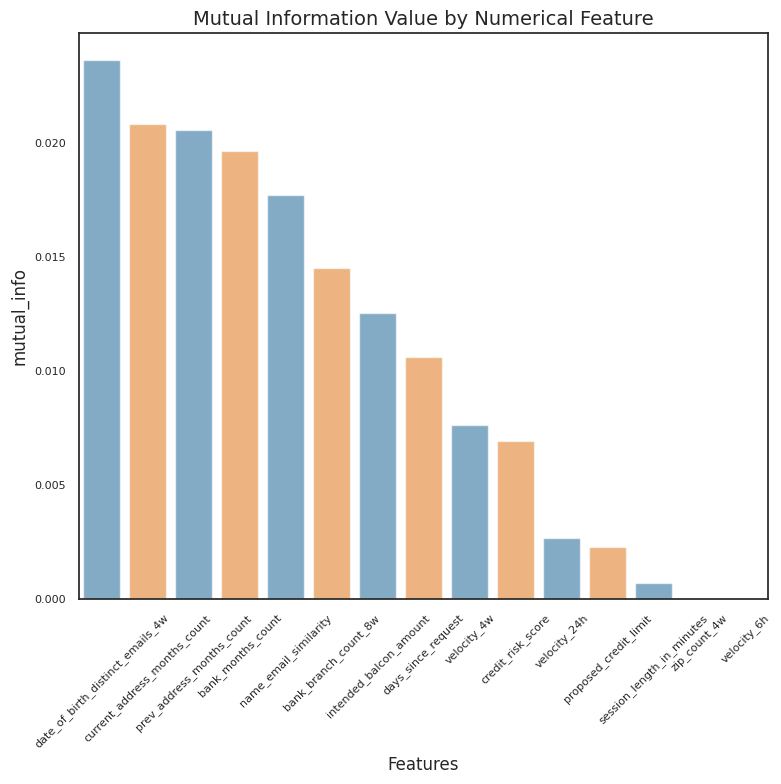

In [25]:
plt.figure(figsize=(8, 8))

# Create bar plot
sns.barplot(data=mi_result_df.sort_values(by='mutual_info', ascending=False), x="feature", y="mutual_info", palette=my_palette, alpha=.6)

# Customize labels and legend
plt.xlabel("Features", fontsize=12)
plt.ylabel("mutual_info", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.title("Mutual Information Value by Numerical Feature", fontsize=14)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [26]:
# Use SelectKBest with mutual information test to select the top 10 numerical features
best_mi= SelectKBest(mutual_info_classif, k=10)
best_mi.fit(X_train_num, y_train_num)

best_mi_features = X_train_num.columns[best_mi.get_support()].tolist()

# Print the names of the top 10 features
print(best_mi_features)

['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count']


In [29]:
features_selected = best_mi_features + best_chi2_features

In [30]:
for i in features_selected:
  print(i)

name_email_similarity
prev_address_months_count
current_address_months_count
days_since_request
intended_balcon_amount
velocity_4w
bank_branch_count_8w
date_of_birth_distinct_emails_4w
credit_risk_score
bank_months_count
income
customer_age
email_is_free
phone_home_valid
has_other_cards
foreign_request
keep_alive_session
payment_type_AA
payment_type_AC
employment_status_CB
employment_status_CC
employment_status_CE
employment_status_CF
housing_status_BA
housing_status_BB
housing_status_BC
housing_status_BE
device_os_linux
device_os_other
device_os_windows


# Modelling / Evaluation

## Model Training and Evaluation Functions

In [34]:
def train_base_model(model, X_train, y_train):
    """
    Trains a base model without any hyperparameter tuning

    Parameters:
    model: Model instance (e.g., RandomForestClassifier, LogisticRegression, etc.).
    X_train: Training features.
    y_train: Training target feature.
    X_test: Testing features.
    y_test: Testing target feature.

    Returns:
    model: the fitted model
    """

    # Create pipeline with the model
    ada = ADASYN(random_state=42)
    pipeline = make_pipeline(ada, model)
    fit_model = pipeline.fit(X_train, y_train)

    return fit_model

def print_classification_report(y_test, y_pred, title):
  """
  Prints the classification report for a fitted model
  """
  # Calculate the classification report
  report = classification_report(y_test, y_pred, target_names=['No Fraud', 'Fraud'])
  # precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred)

  print(title)
  print('******' * 10)
  print(report)
  #  target_names=['No Fraud', 'Fraud']
  return

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, label='ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve')
    plt.legend()
    plt.show()

def plot_roc_curves(fpr, tpr, labels):
    plt.figure(figsize=(8, 8))
    for i in range(len(fpr)):
        # Compute the ROC AUC score
        roc_auc_score = auc(fpr[i], tpr[i])
        # Plot the ROC curve
        plt.plot(fpr[i], tpr[i], label=f'{labels[i]} (AUC={roc_auc_score:.2f})')

    # Plot the random classifier curve
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # Set the plot labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def test_classifier(model, X_test, y_test, model_name, FIXED_FPR = 0.05):
    """
    Evaluates a fitted classifier model on test data and returns evaluation metrics,
    predictions, and recalls at a fixed False Positive Rate Threshold.

    Arguments:
    - model: Fitted classifier model
    - X_test: Test features
    - y_test: True labels for test data
    - FIXED_FPR: Threshold FPR 5%

    Returns:
    - Dictionary containing evaluation metrics (accuracy, precision, f1-score)
    - fpr: False positive rates
    - tpr: True positive rates
    - default_recall: Recall at default threshold (0.5)
    - threshold_recall: Recall at the threshold corresponding to 5% FPR
    """

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    fprs, tprs, thresholds = roc_curve(y_test, y_prob)
    threshold = thresholds[fprs<FIXED_FPR][-1]
    y_pred_threshold = (y_prob >= threshold).astype(int)

    tpr = tprs[fprs<FIXED_FPR][-1]
    fpr = fprs[fprs<FIXED_FPR][-1]

    default_recall = recall_score(y_test, y_pred)
    threshold_recall = recall_score(y_test, y_pred_threshold)

    precision = precision_score(y_test, y_pred)
    threshold_precision = precision_score(y_test, y_pred_threshold)

    predictive_equality, fairness_metrics = get_fairness_metrics(y_test, y_prob, groups, FIXED_FPR)

    plot_roc(fprs, tprs)

    to_pct = lambda x: str(round(x, 4) * 100) + "%"

    print("")
    print("Precision:", to_pct(precision))
    print("Recall:", to_pct(default_recall))
    print("AUC:", roc_auc_score(y_test, y_prob))
    print("5% FPR Threshold: ", round(threshold, 2))
    print("Recall @5% FPR: ", to_pct(tpr))
    print("Precision @5% FPR: ", to_pct(threshold_precision))
    print("Predictive Equality @5% FPR: ", to_pct(predictive_equality))
    print("")

    # Print the classification report at the target threshold
    print_classification_report(y_test, y_pred, title=f'Classification Report')

    return fprs, tprs, default_recall, threshold_recall

def get_fairness_metrics(y_true, y_pred, groups, FIXED_FPR):
    g = Group()
    aequitas_df = pd.DataFrame(
        {"score": y_pred,
         "label_value": y_true,
         "group": groups}
    )
    # Use aequitas to compute confusion matrix metrics for every group.
    fairness_metrics = g.get_crosstabs(aequitas_df, score_thresholds={"score_val": [FIXED_FPR]})[0]

    # Predictive equality is the differences in FPR (we use ratios in the paper)
    predictive_equality = fairness_metrics["fpr"].min() / fairness_metrics["fpr"].max()

    return predictive_equality, fairness_metrics

## Base Models

In [32]:
sns.set(style="whitegrid")

In [33]:
X_train = X_train[features_selected].copy()
X_test = X_test[features_selected].copy()

### Logistic Regression

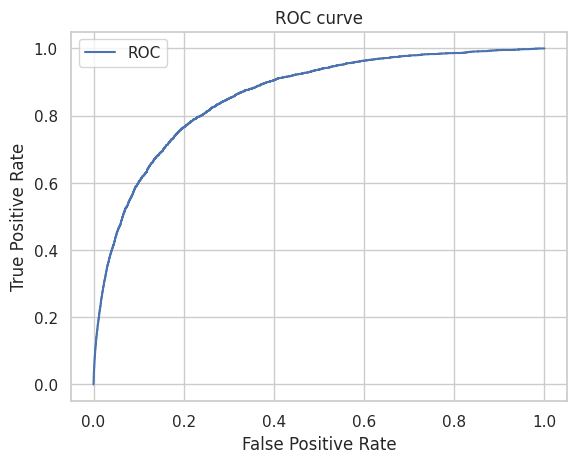


Precision: 4.9%
Recall: 78.32000000000001%
AUC: 0.8606976161434272
5% FPR Threshold:  0.76
Recall @5% FPR:  44.269999999999996%
Precision @5% FPR:  11.200000000000001%
Predictive Equality @5% FPR:  96.07%

Classification Report
************************************************************
              precision    recall  f1-score   support

    No Fraud       1.00      0.78      0.88    202133
       Fraud       0.05      0.78      0.09      2878

    accuracy                           0.78    205011
   macro avg       0.52      0.78      0.48    205011
weighted avg       0.98      0.78      0.87    205011

CPU times: user 5.37 s, sys: 1.7 s, total: 7.06 s
Wall time: 1.83 s


In [35]:
%%time
logistic_reg = LogisticRegression(max_iter=1000)
lg_base = train_base_model(logistic_reg, X_train, y_train)
lg_fpr, lg_tpr, lg_default_recall, lg_target_recall = test_classifier(lg_base, X_test, y_test, "Base Logistic Regression")

### Decision Tree

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


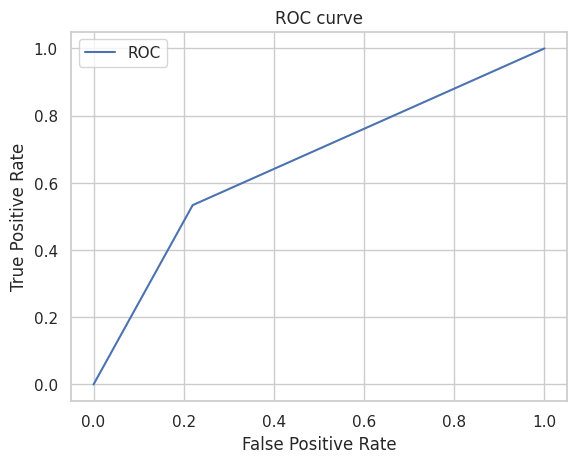


Precision: 3.34%
Recall: 53.37%
AUC: 0.6569070432977534
5% FPR Threshold:  2.0
Recall @5% FPR:  0.0%
Precision @5% FPR:  0.0%
Predictive Equality @5% FPR:  57.97%

Classification Report
************************************************************
              precision    recall  f1-score   support

    No Fraud       0.99      0.78      0.87    202133
       Fraud       0.03      0.53      0.06      2878

    accuracy                           0.78    205011
   macro avg       0.51      0.66      0.47    205011
weighted avg       0.98      0.78      0.86    205011

CPU times: user 5.71 s, sys: 214 ms, total: 5.92 s
Wall time: 2.48 s


In [36]:
%%time
dec_tree = DecisionTreeClassifier(class_weight='balanced')
dt_base = train_base_model(dec_tree, X_train, y_train)
dt_fpr, dt_tpr, dt_default_recall, dt_target_recall = test_classifier(dt_base, X_test, y_test, 'Base Decision Tree')

### Random Forest

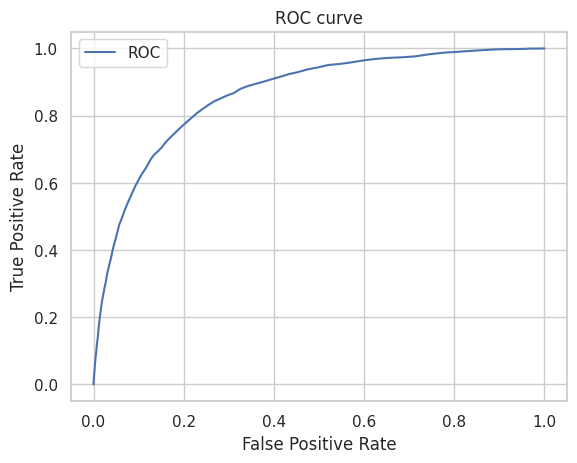


Precision: 8.02%
Recall: 60.67%
AUC: 0.8645908601581368
5% FPR Threshold:  0.61
Recall @5% FPR:  43.47%
Precision @5% FPR:  11.16%
Predictive Equality @5% FPR:  92.72%

Classification Report
************************************************************
              precision    recall  f1-score   support

    No Fraud       0.99      0.90      0.95    202133
       Fraud       0.08      0.61      0.14      2878

    accuracy                           0.90    205011
   macro avg       0.54      0.75      0.54    205011
weighted avg       0.98      0.90      0.93    205011

CPU times: user 28.2 s, sys: 270 ms, total: 28.5 s
Wall time: 22 s


In [37]:
%%time
random_forest = RandomForestClassifier(class_weight='balanced')
rf_base = train_base_model(random_forest, X_train, y_train)
rf_fpr, rf_tpr, rf_default_recall, rf_target_recall = test_classifier(rf_base, X_test, y_test, "Base Random Forest")

### Light Gradient Boosting


[LightGBM] [Info] Number of positive: 20678, number of negative: 20000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6236
[LightGBM] [Info] Number of data points in the train set: 40678, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508334 -> initscore=0.033338
[LightGBM] [Info] Start training from score 0.033338


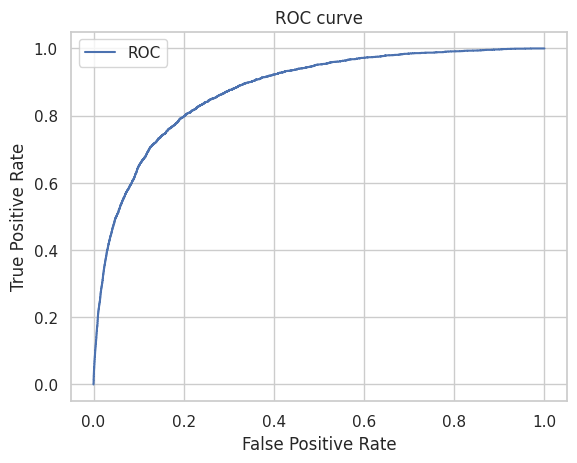


Precision: 8.83%
Recall: 61.61%
AUC: 0.8784397513788552
5% FPR Threshold:  0.62
Recall @5% FPR:  49.93%
Precision @5% FPR:  12.47%
Predictive Equality @5% FPR:  80.47999999999999%

Classification Report
************************************************************
              precision    recall  f1-score   support

    No Fraud       0.99      0.91      0.95    202133
       Fraud       0.09      0.62      0.15      2878

    accuracy                           0.91    205011
   macro avg       0.54      0.76      0.55    205011
weighted avg       0.98      0.91      0.94    205011

CPU times: user 10.1 s, sys: 252 ms, total: 10.4 s
Wall time: 3.03 s


In [38]:
%%time
lightgbm = LGBMClassifier(device='cpu')
lgb_base = train_base_model(lightgbm, X_train, y_train)
lgb_fpr, lgb_tpr, lgb_default_recall, lgb_target_recall = test_classifier(lgb_base, X_test, y_test, "Base LightGBM")

In [39]:
import joblib
# Save the models to a file
joblib.dump(lg_base, '/content/drive/MyDrive/Research/lg.joblib')
joblib.dump(dt_base, '/content/drive/MyDrive/Research/dt.joblib')
joblib.dump(rf_base, '/content/drive/MyDrive/Research/rf.joblib')
joblib.dump(lgb_base, '/content/drive/MyDrive/Research/lgb.joblib')


['/content/drive/MyDrive/Research/lgb.joblib']

### ROC Curves and Recall Plots

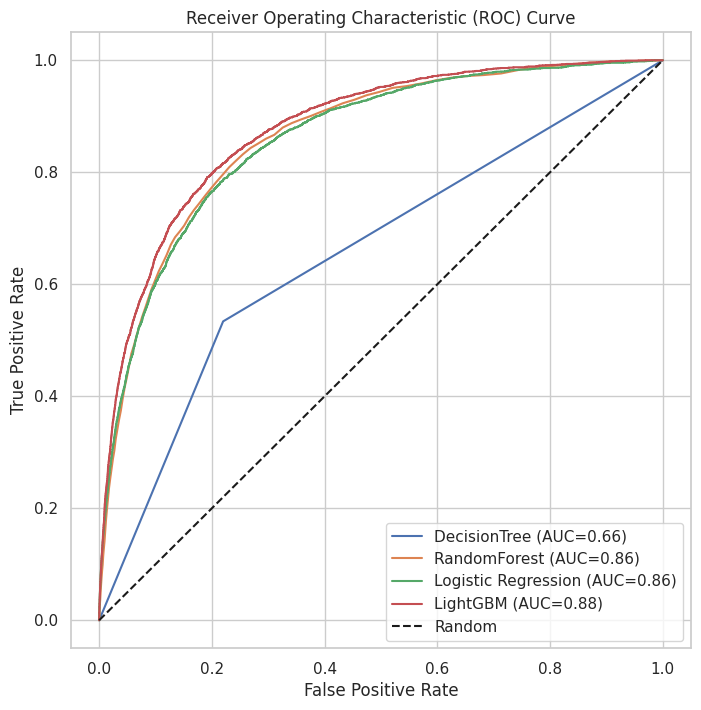

In [42]:
sns.set(style="whitegrid")
fpr = [dt_fpr, rf_fpr, lg_fpr, lgb_fpr]
tpr = [dt_tpr, rf_tpr, lg_tpr, lgb_tpr]
labels = ['DecisionTree', 'RandomForest', 'Logistic Regression', 'LightGBM']

# Plot ROC curves for each classifier using the FPR, TPR, and label lists
plot_roc_curves(fpr, tpr, labels)

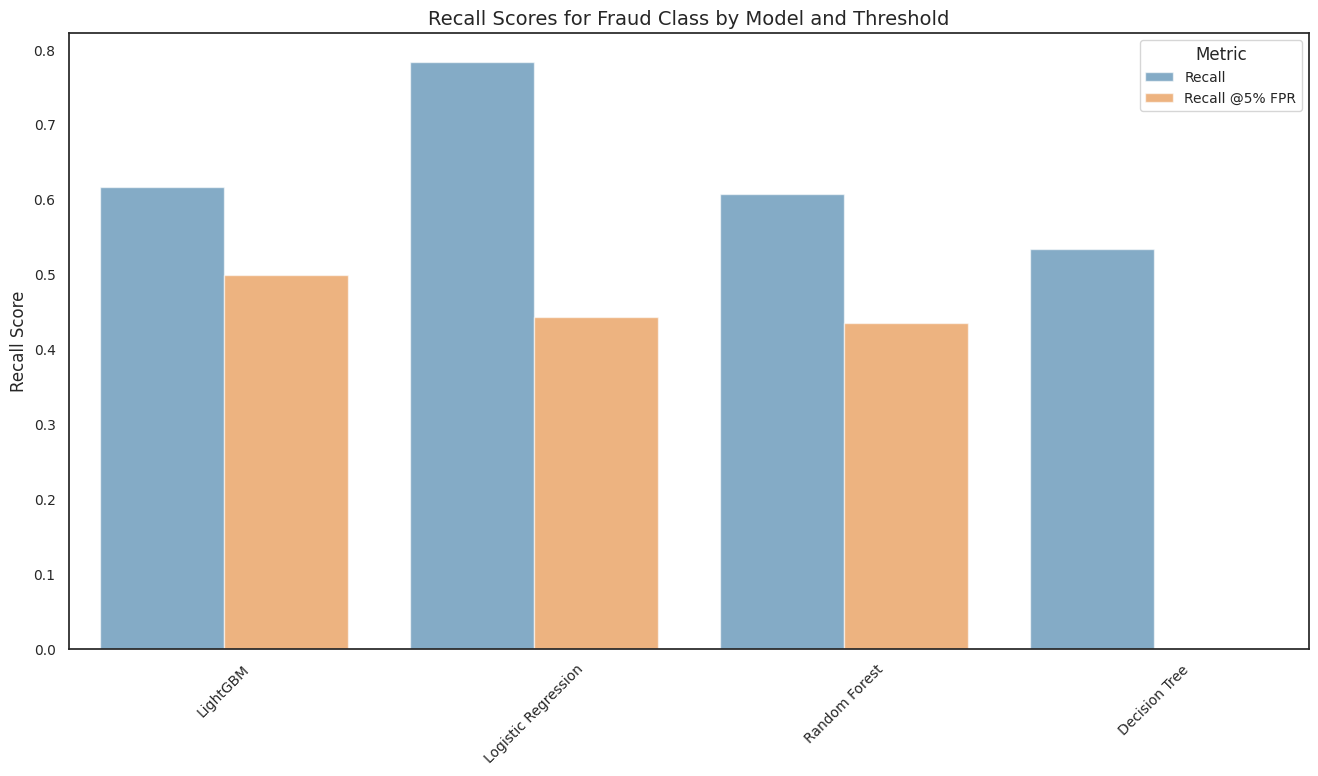

In [46]:
data = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Logistic Regression', 'LightGBM'],
    'Recall': [dt_default_recall, rf_default_recall, lg_default_recall, lgb_default_recall],
    'Recall @5% FPR': [dt_target_recall, rf_target_recall, lg_target_recall, lgb_target_recall]
})

# Sort the data by the threshold recall score in descending order
data = data.sort_values(by='Recall @5% FPR', ascending=False)

# Reshape the data
data = pd.melt(data, id_vars='Model', var_name='Metric', value_name='Score')

sns.set(style="white")
# Set up plot
plt.figure(figsize=(16, 8))

# Create grouped bar plot
sns.barplot(
    data=data,
    x='Model',
    y='Score',
    hue='Metric',
    palette=my_palette,
    alpha=.6,
)

# Customize labels and legend
plt.xlabel("")
plt.ylabel("Recall Score", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.title("Recall Scores for Fraud Class by Model and Threshold", fontsize=14)
plt.legend(title="Metric", fontsize=10)

# Display plot
plt.show()

## Hyperparameter Tuning with GridSearchCV

In [54]:
def train_tuned_model(model, params, X_train, y_train):
    """
    Train a classifier using the specified parameters and return the trained model.

    Parameters:
    model: The model to train.
    params: The model parameters to we intend to tune.
    X_train: The training features.
    y_train: The target feauture.
    encoded_cat_features: list of encoded categorical features.

    Returns:trained classifier.
    """
    # Create pipeline with SMOTENC and the model
    ada = ADASYN(random_state=42)
    pipeline = make_pipeline(ada, model)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)
    classifier = GridSearchCV(estimator=pipeline,
                                  param_grid=params,
                                  scoring="recall",
                                  n_jobs=-1,
                                  cv=cv)


    # Fit the model and return the trained classifier
    classifier.fit(X_train, y_train)

    return classifier

### Tuned Logistic Regression

In [55]:
sns.set(style="whitegrid")

{'logisticregression__C': 0.01, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}


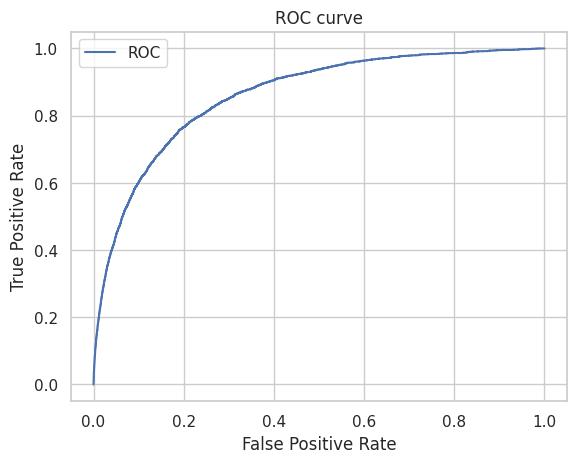


Precision: 4.88%
Recall: 78.42%
AUC: 0.861060400969594
5% FPR Threshold:  0.75
Recall @5% FPR:  44.41%
Precision @5% FPR:  11.23%
Predictive Equality @5% FPR:  96.45%

Classification Report
************************************************************
              precision    recall  f1-score   support

    No Fraud       1.00      0.78      0.88    202133
       Fraud       0.05      0.78      0.09      2878

    accuracy                           0.78    205011
   macro avg       0.52      0.78      0.48    205011
weighted avg       0.98      0.78      0.87    205011

CPU times: user 8.61 s, sys: 2.15 s, total: 10.8 s
Wall time: 2min 17s


In [56]:
%%time
lg = LogisticRegression()
lg_params = param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['liblinear', 'saga'],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__max_iter': [100, 200, 500, 1000]
}
lg_tuned = train_tuned_model(lg, lg_params, X_train, y_train)
print(lg_tuned.best_params_)
lgt_fpr, lgt_tpr, lgt_default_recall, lgt_target_recall = test_classifier(lg_tuned, X_test, y_test, "Tuned Logistic Regression")

### Tuned Decision Tree

{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__max_features': 'log2', 'decisiontreeclassifier__min_samples_leaf': 2, 'decisiontreeclassifier__min_samples_split': 10, 'decisiontreeclassifier__splitter': 'random'}


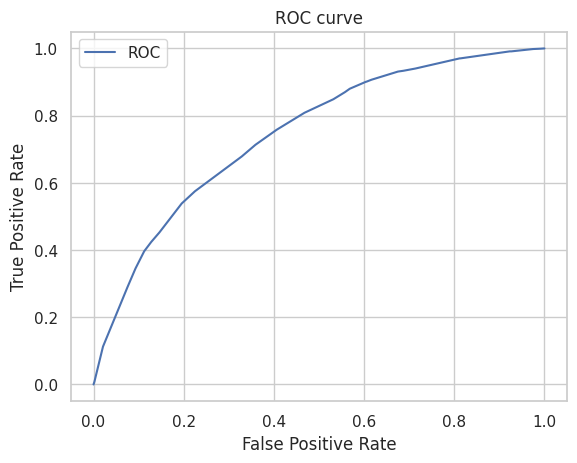


Precision: 2.59%
Recall: 75.82%
AUC: 0.7462995822245123
5% FPR Threshold:  0.81
Recall @5% FPR:  11.26%
Precision @5% FPR:  7.109999999999999%
Predictive Equality @5% FPR:  99.96000000000001%

Classification Report
************************************************************
              precision    recall  f1-score   support

    No Fraud       0.99      0.59      0.74    202133
       Fraud       0.03      0.76      0.05      2878

    accuracy                           0.60    205011
   macro avg       0.51      0.68      0.40    205011
weighted avg       0.98      0.60      0.73    205011

CPU times: user 34.8 s, sys: 2.42 s, total: 37.2 s
Wall time: 12min 58s


In [57]:
%%time
dt = DecisionTreeClassifier()
dt_params = {
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__splitter': ['best', 'random'],
    'decisiontreeclassifier__max_depth': [None, 5, 10, 15, 20],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
    'decisiontreeclassifier__max_features': [None, 'sqrt', 'log2']
}
dt_tuned = train_tuned_model(dt, dt_params, X_train, y_train)
print(dt_tuned.best_params_)
dtt_fpr, dtt_tpr, dtt_default_recall, dtt_target_recall = test_classifier(dt_tuned, X_test, y_test, "Tuned Decision Tree")

### Tuned RandomForest

{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 50}


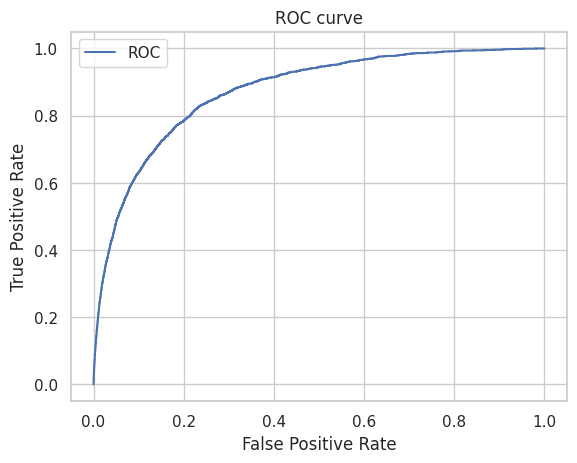


Precision: 6.34%
Recall: 72.69%
AUC: 0.8731950734643655
5% FPR Threshold:  0.65
Recall @5% FPR:  48.26%
Precision @5% FPR:  12.09%
Predictive Equality @5% FPR:  98.45%

Classification Report
************************************************************
              precision    recall  f1-score   support

    No Fraud       1.00      0.85      0.92    202133
       Fraud       0.06      0.73      0.12      2878

    accuracy                           0.85    205011
   macro avg       0.53      0.79      0.52    205011
weighted avg       0.98      0.85      0.90    205011

CPU times: user 21.8 s, sys: 2.23 s, total: 24 s
Wall time: 16min 50s


In [58]:
%%time
rf = RandomForestClassifier()
rf_params = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_depth': [10, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__max_features': ['sqrt', 'log2']
}
rf_tuned = train_tuned_model(rf, rf_params, X_train, y_train)
print(rf_tuned.best_params_)
rft_fpr, rft_tpr, rft_default_recall, rft_target_recall = test_classifier(rf_tuned, X_test, y_test, "Tuned Randon Forest")

### Tuned LightGBM

[LightGBM] [Info] Number of positive: 20678, number of negative: 20000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6236
[LightGBM] [Info] Number of data points in the train set: 40678, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508334 -> initscore=0.033338
[LightGBM] [Info] Start training from score 0.033338
{'lgbmclassifier__learning_rate': 0.05, 'lgbmclassifier__max_depth': 2, 'lgbmclassifier__subsample': 0.6}


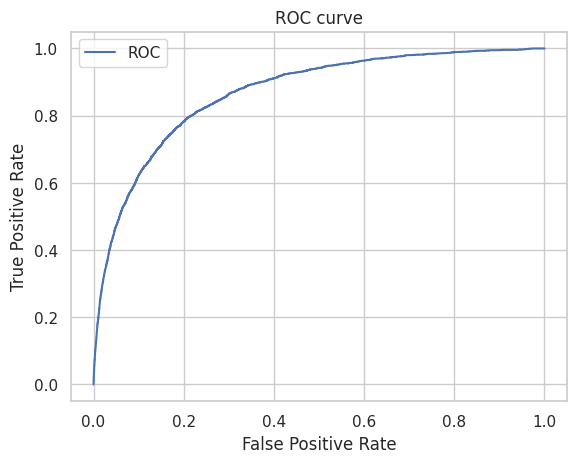


Precision: 6.329999999999999%
Recall: 71.26%
AUC: 0.8683840446571298
5% FPR Threshold:  0.62
Recall @5% FPR:  47.12%
Precision @5% FPR:  11.84%
Predictive Equality @5% FPR:  99.75%

Classification Report
************************************************************
              precision    recall  f1-score   support

    No Fraud       1.00      0.85      0.92    202133
       Fraud       0.06      0.71      0.12      2878

    accuracy                           0.85    205011
   macro avg       0.53      0.78      0.52    205011
weighted avg       0.98      0.85      0.91    205011

CPU times: user 2min 20s, sys: 24.4 s, total: 2min 44s
Wall time: 5h 4min 45s


In [60]:
%%time
lgb = LGBMClassifier(device='cpu', n_jobs=-1)
lgb_params = {'lgbmclassifier__max_depth': [2, 4, 6, 8, 10],
              'lgbmclassifier__subsample': [0.6, 0.8, 1.0],
              'lgbmclassifier__learning_rate': [0.05, 0.1, 0.2],
              }
lgb_tuned = train_tuned_model(lgb, lgb_params, X_train, y_train)
print(lgb_tuned.best_params_)
lgbt_fpr, lgbt_tpr, lgbt_default_recall, lgbt_target_recall = test_classifier(lgb_tuned, X_test, y_test, "Tuned LightGBM")

## Evaluation

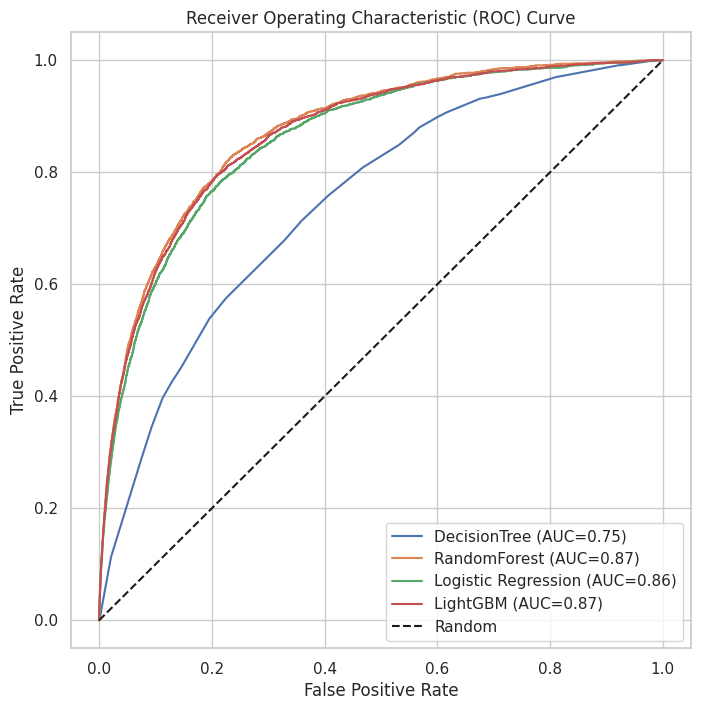

In [83]:
sns.set(style="whitegrid")
fpr = [dtt_fpr, rft_fpr, lgt_fpr, lgbt_fpr]
tpr = [dtt_tpr, rft_tpr, lgt_tpr, lgbt_tpr]
labels = ['DecisionTree', 'RandomForest', 'Logistic Regression', 'LightGBM']
plot_roc_curves(fpr, tpr, labels)

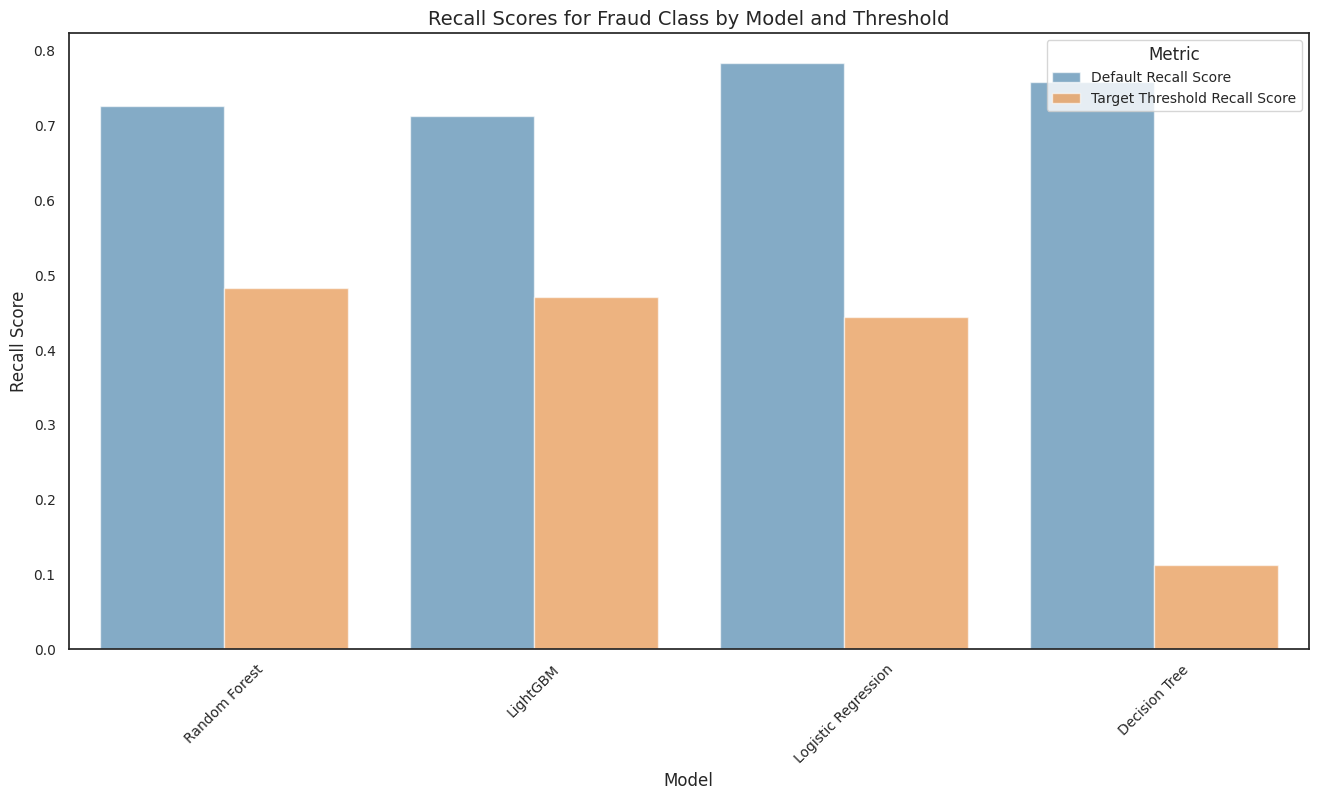

In [84]:
data = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Logistic Regression', 'LightGBM'],
    'Default Recall Score': [dtt_default_recall, rft_default_recall, lgt_default_recall, lgbt_default_recall],
    'Target Threshold Recall Score': [dtt_target_recall, rft_target_recall, lgt_target_recall, lgbt_target_recall]
})

# Sort the data by the threshold recall score in descending order
data = data.sort_values(by='Target Threshold Recall Score', ascending=False)

# Reshape the data
data = pd.melt(data, id_vars='Model', var_name='Metric', value_name='Score')

sns.set(style="white")
plt.figure(figsize=(16, 8))

# Create grouped bar plot
sns.barplot(
    data=data,
    x='Model',
    y='Score',
    hue='Metric',
    palette=my_palette,
    alpha=.6,
)

# Customize labels and legend
plt.xlabel("Model", fontsize=12)
plt.ylabel("Recall Score", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.title("Recall Scores for Fraud Class by Model and Threshold", fontsize=14)
plt.legend(title="Metric", fontsize=10)

# Display plot
plt.show()

In [63]:
# Save the models to a file
joblib.dump(lg_tuned, '/content/drive/MyDrive/Research/lg_tuned.joblib')
joblib.dump(dt_tuned, '/content/drive/MyDrive/Research/dt_tuned.joblib')
joblib.dump(rf_tuned, '/content/drive/MyDrive/Research/rf_tuned.joblib')
joblib.dump(lgb_tuned, '/content/drive/MyDrive/Research/lgb_tuned.joblib')

['/content/drive/MyDrive/Research/lgb_tuned.joblib']